In [1]:
import sys
sys.path.append('/home/shiftpub/Dynamic_AMM/exp')
from metrics_plot import plot_value_and_vega_comparison, subplot_comparison
import numpy as np
import polars as pl

output_dir = '/home/shiftpub/Dynamic_AMM/two_step_exp/output/two_step_metrics.parquet'
df = pl.read_parquet(output_dir)
# print unique metrics
print(f"Unique metrics: {df['metric'].unique()}")


Unique metrics: shape: (4,)
Series: 'metric' [str]
[
	"arbitrageur_revenue"
	"accounting_profit"
	"pool_value"
	"fee_revenue"
]


## 1. Expected Fee

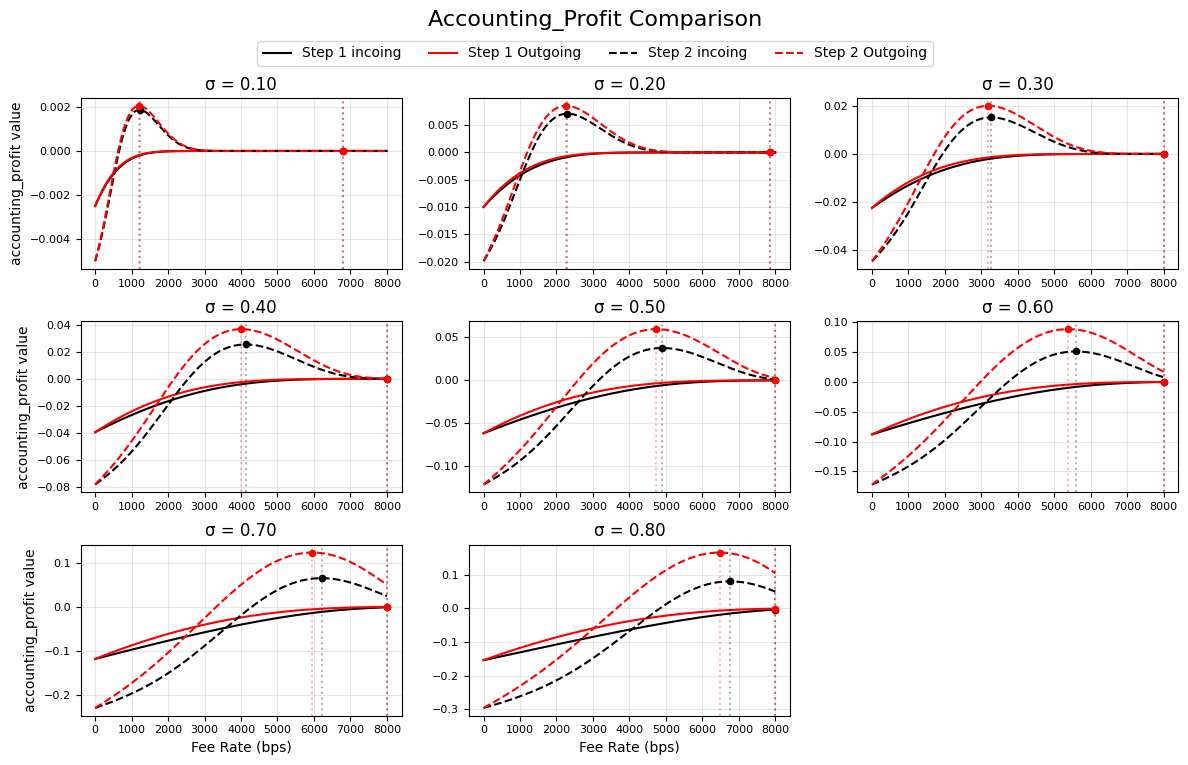

In [2]:
metric = 'accounting_profit'
subplot_comparison(output_dir,
                metric=metric)
# plot_value_and_vega_comparison(path=output_dir, metric=metric)

## 2. Pool Value

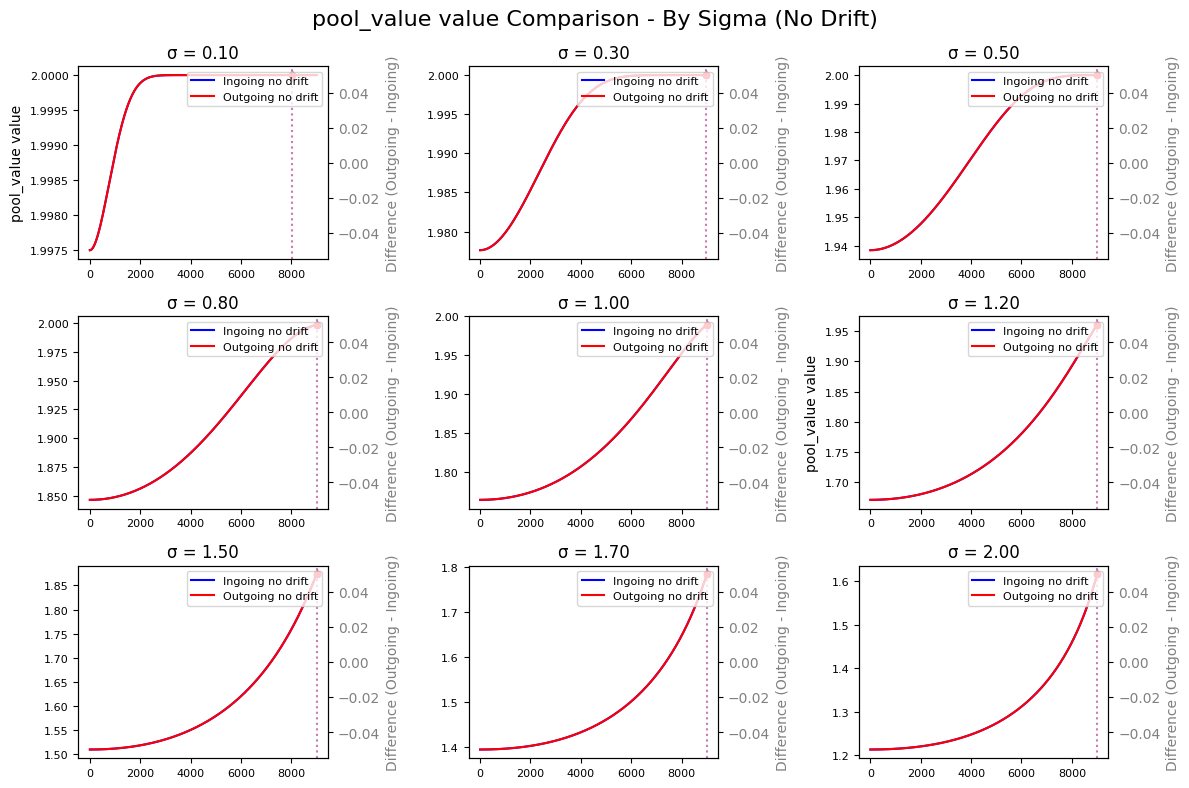

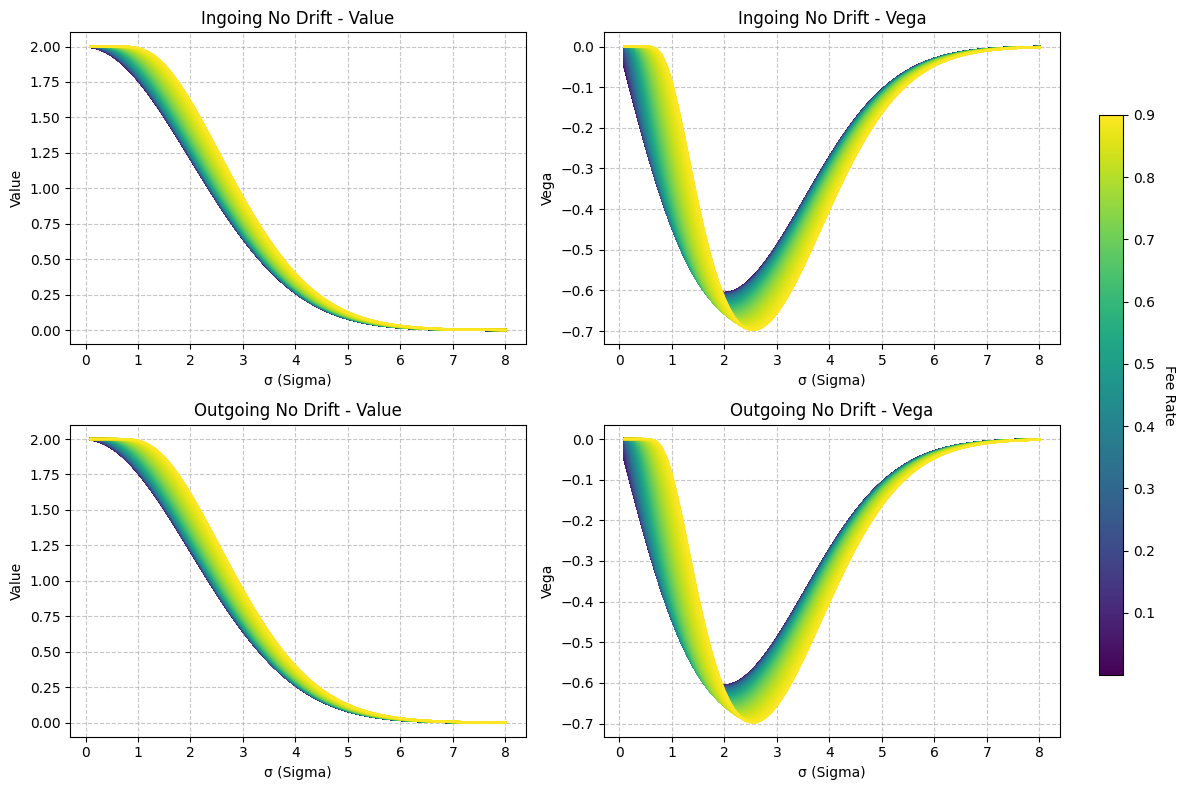

In [3]:
metric = 'pool_value'
subplot_comparison(output_dir,
                metric=metric,
                drift=False,
                plot_rows=3,
                max_plots=1,
                value_type='value',
                subplot_by='sigma',
                max_sigma=2.0)
plot_value_and_vega_comparison(path=output_dir, metric=metric)

## 3. Trader PNL

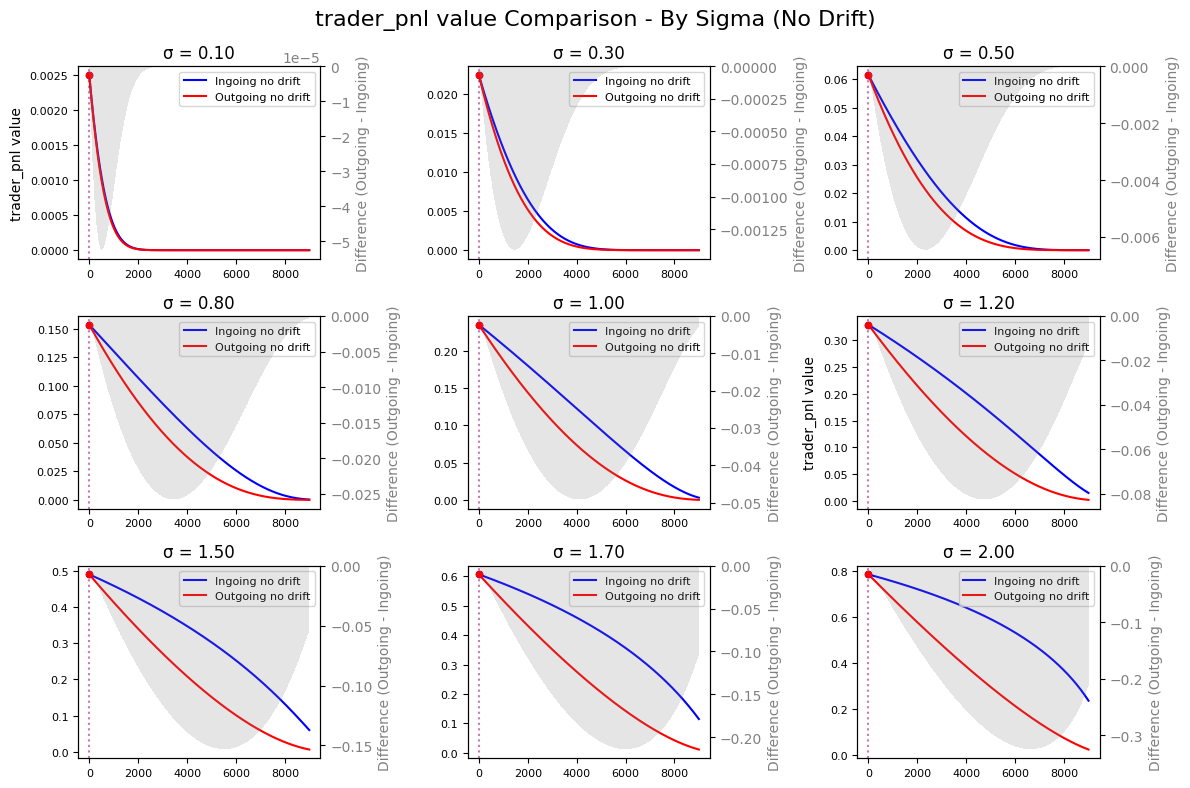

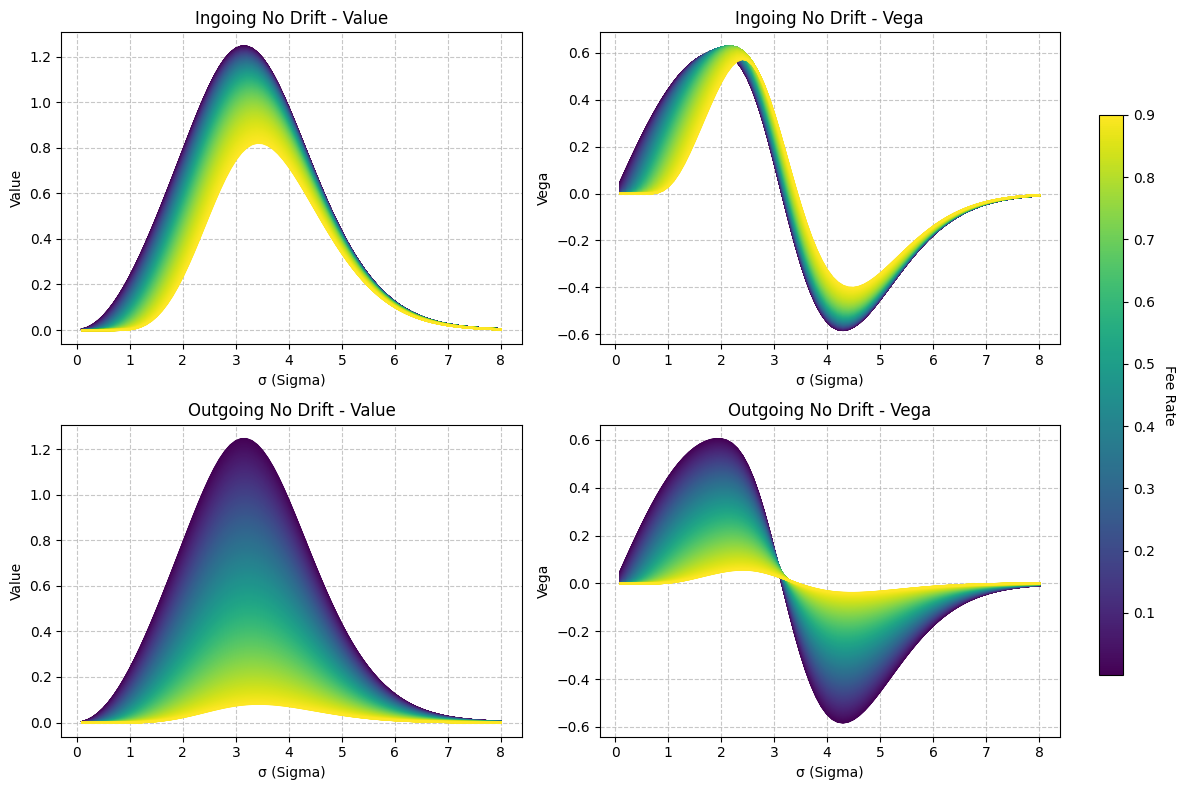

In [3]:
metric = 'trader_pnl'
subplot_comparison(output_dir,
                metric=metric,
                drift=False,
                plot_rows=3,
                max_plots=1,
                value_type='value',
                subplot_by='sigma',
                max_sigma=2.0)
plot_value_and_vega_comparison(path=output_dir, metric=metric)

## 4. Impermanent Loss

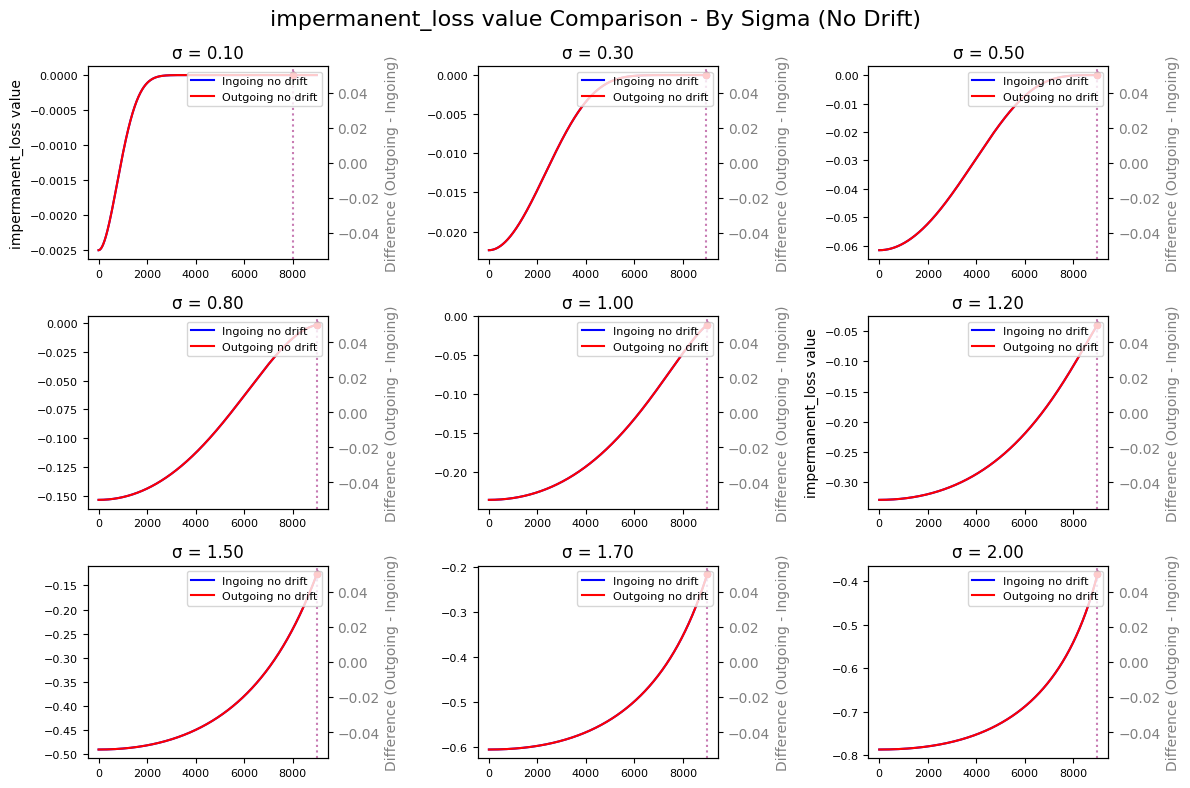

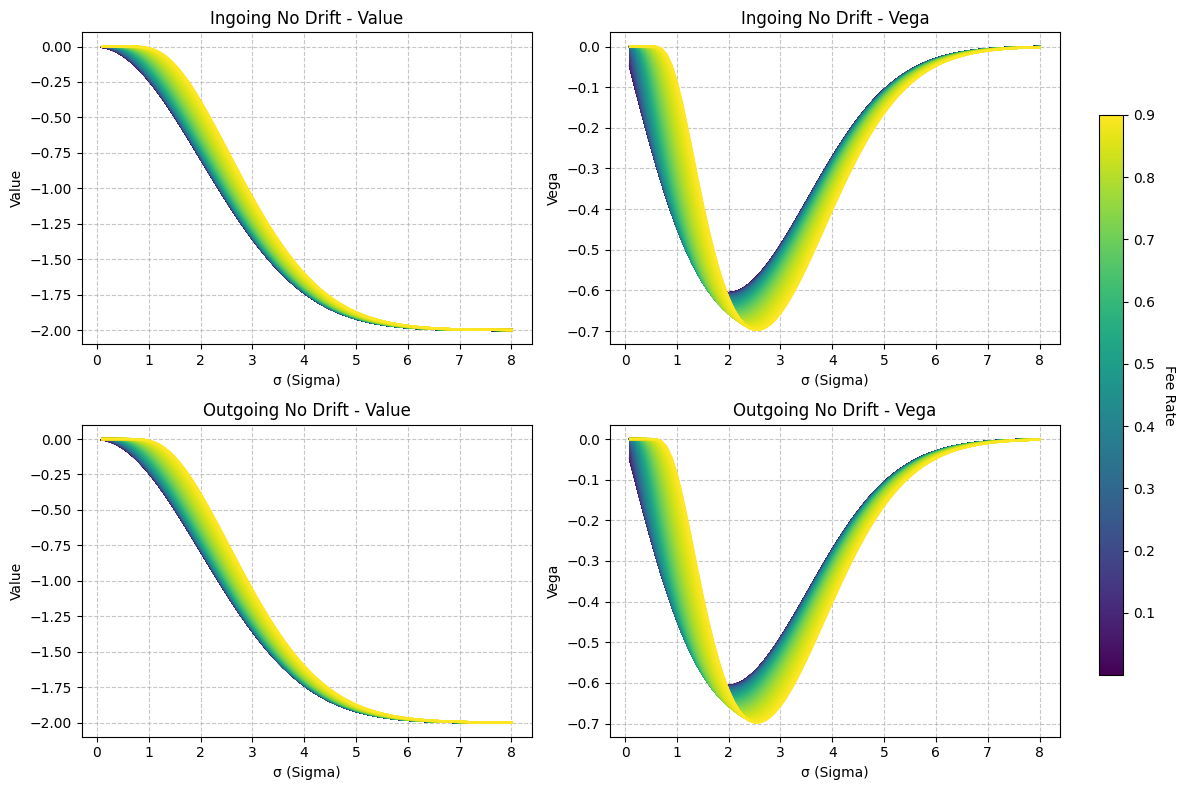

In [5]:
metric = 'impermanent_loss'
subplot_comparison(output_dir,
                metric=metric,
                drift=False,
                plot_rows=3,
                max_plots=1,
                value_type='value',
                subplot_by='sigma',
                max_sigma=2.0)
plot_value_and_vega_comparison(path=output_dir, metric=metric)

In [6]:
## 5. Net Profit

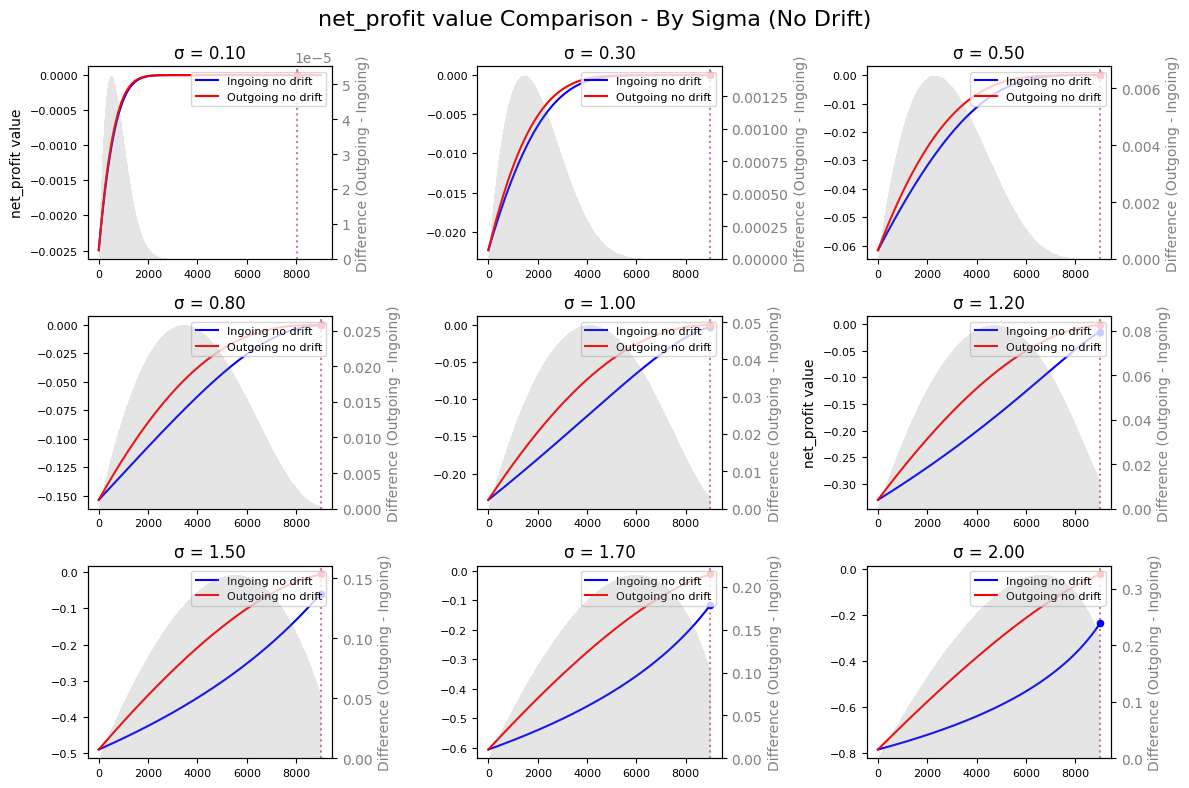

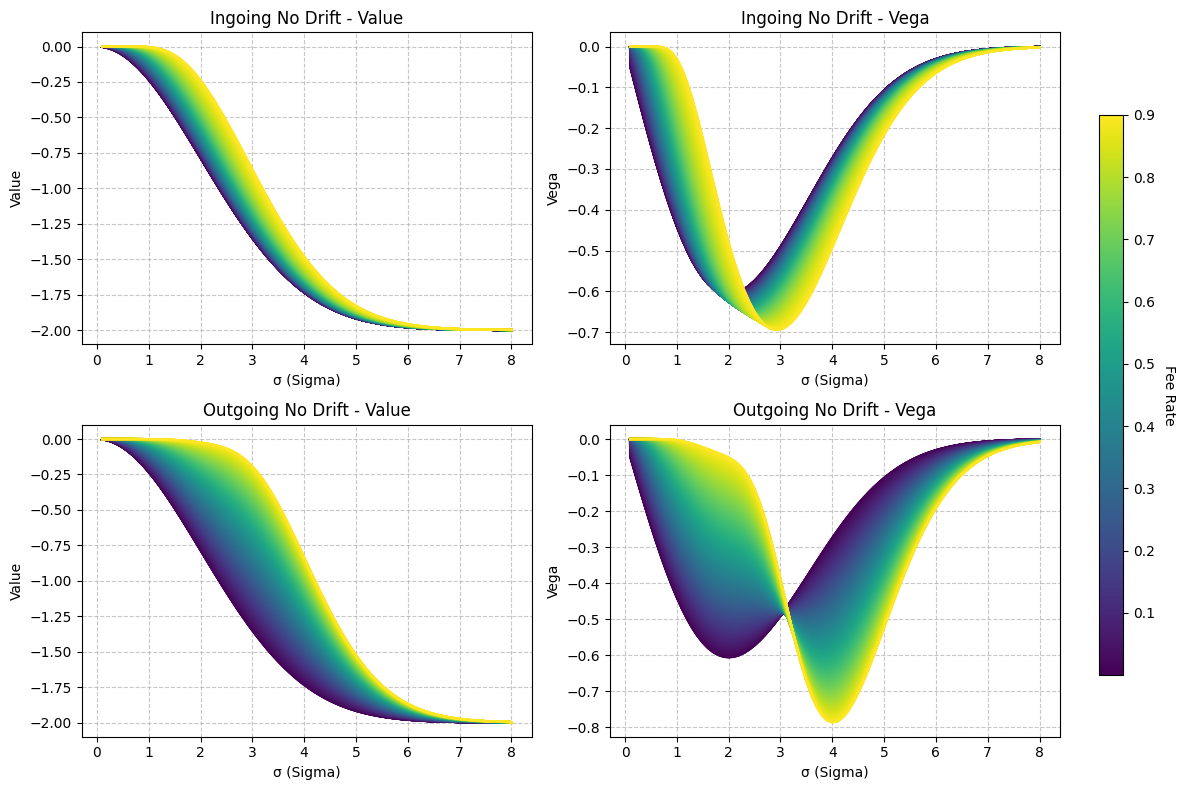

In [7]:
metric = 'net_profit'
subplot_comparison(output_dir,
                metric=metric,
                drift=False,
                plot_rows=3,
                max_plots=1,
                value_type='value',
                subplot_by='sigma',
                max_sigma=2.0)
plot_value_and_vega_comparison(path=output_dir, metric=metric)

## 6. Accounting Profit

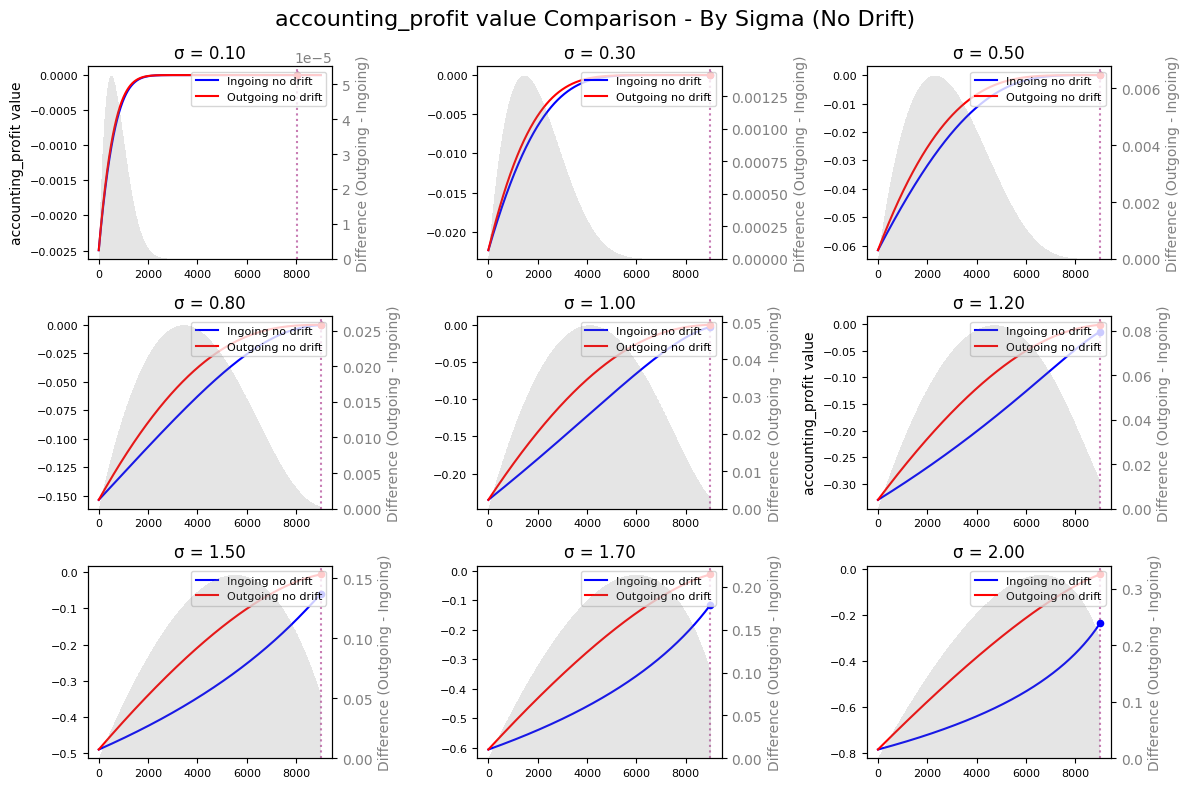

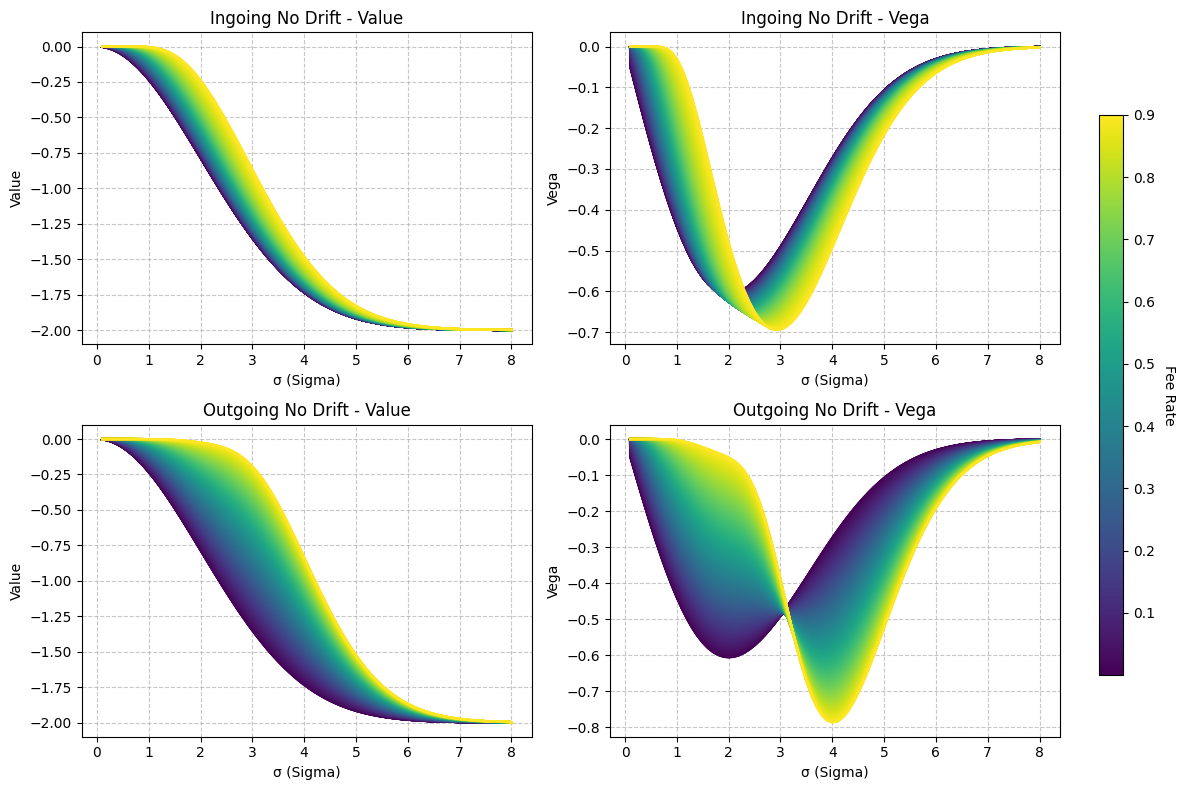

In [8]:
metric = 'accounting_profit'
subplot_comparison(output_dir,
                metric=metric,
                drift=False,
                plot_rows=3,
                max_plots=1,
                value_type='value',
                subplot_by='sigma',
                max_sigma=2.0)
plot_value_and_vega_comparison(path=output_dir, metric=metric)


Numerical Values:
σ		First Integral	Second Integral	Total PnL
------------------------------------------------------------
0.10		0.001155	0.001155	0.002311
0.15		0.002650	0.002650	0.005300
0.20		0.004754	0.004754	0.009508
0.25		0.007462	0.007462	0.014925
0.30		0.010771	0.010771	0.021542
0.35		0.014673	0.014673	0.029346
0.40		0.019162	0.019162	0.038324
0.45		0.024230	0.024230	0.048459
0.50		0.029866	0.029866	0.059732
0.55		0.036062	0.036062	0.072123
0.59		0.042805	0.042805	0.085610
0.64		0.050084	0.050084	0.100168
0.69		0.057886	0.057886	0.115772
0.74		0.066197	0.066197	0.132393
0.79		0.075001	0.075001	0.150003
0.84		0.084285	0.084285	0.168570
0.89		0.094031	0.094031	0.188062
0.94		0.104223	0.104223	0.208446
0.99		0.114843	0.114843	0.229686
1.04		0.125874	0.125874	0.251747
1.09		0.137296	0.137296	0.274591
1.14		0.149090	0.149090	0.298181
1.19		0.161238	0.161238	0.322477
1.24		0.173719	0.173719	0.347439
1.29		0.186514	0.186514	0.373028
1.34		0.199601	0.199601	0.399202
1.39		0.212960	0.2

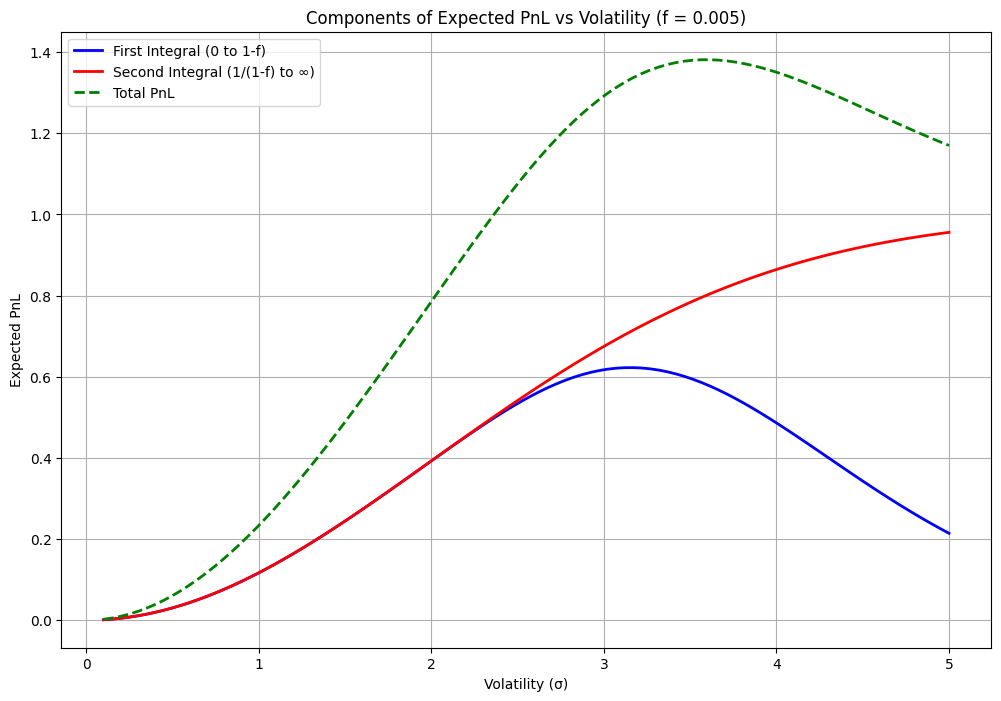

In [12]:
import numpy as np
from scipy.stats import lognorm
from scipy.integrate import quad
import matplotlib.pyplot as plt

def calculate_pnl_components(f: float, sigma: float, ls: float = 1.0):
    """Calculate both integrals separately and their sum"""
    
    def integrand1(v, f, ls):
        # First integral: (1 - sqrt(v/(1-f)))^2
        return ls * (1 - np.sqrt(v/(1-f)))**2 * lognorm.pdf(v, s=sigma, scale=np.exp(-0.5*sigma**2))
    
    def integrand2(v, f, ls):
        # Second integral: (sqrt(v) - sqrt(1/(1-f)))^2
        return ls * (np.sqrt(v) - np.sqrt(1/(1-f)))**2 * lognorm.pdf(v, s=sigma, scale=np.exp(-0.5*sigma**2))
    
    # Calculate first integral from 0 to 1-f
    result1, _ = quad(integrand1, 1e-4, 1-f, args=(f, ls))
    
    # Calculate second integral from 1/(1-f) to infinity
    result2, _ = quad(integrand2, 1/(1-f), np.inf, args=(f, ls))
    
    return result1, result2, result1 + result2

# Test parameters
f = 0.005  # Fixed fee rate
sigma_values = np.linspace(0.1, 5.0, 100)  # Range of sigma values

# Calculate results for different sigma values
results = [calculate_pnl_components(f, sigma) for sigma in sigma_values]
integral1_values = [r[0] for r in results]
integral2_values = [r[1] for r in results]
total_values = [r[2] for r in results]

# Create the visualization
plt.figure(figsize=(12, 8))

# Plot each component
plt.plot(sigma_values, integral1_values, 'b-', label='First Integral (0 to 1-f)', linewidth=2)
plt.plot(sigma_values, integral2_values, 'r-', label='Second Integral (1/(1-f) to ∞)', linewidth=2)
plt.plot(sigma_values, total_values, 'g--', label='Total PnL', linewidth=2)

plt.xlabel('Volatility (σ)')
plt.ylabel('Expected PnL')
plt.title(f'Components of Expected PnL vs Volatility (f = {f})')
plt.legend()
plt.grid(True)

# Add a table with numerical values
print("\nNumerical Values:")
print("σ\t\tFirst Integral\tSecond Integral\tTotal PnL")
print("-" * 60)
for i in range(len(sigma_values)):
    print(f"{sigma_values[i]:.2f}\t\t{integral1_values[i]:.6f}\t{integral2_values[i]:.6f}\t{total_values[i]:.6f}")

plt.show()


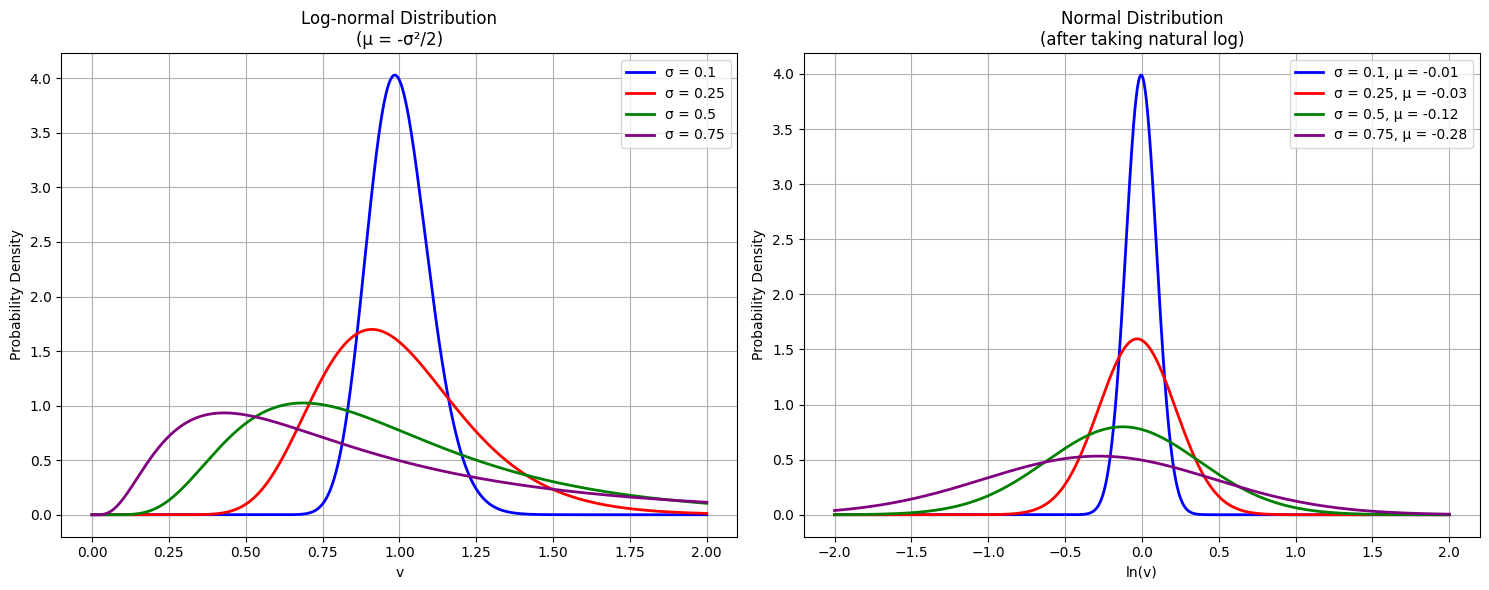


Key Statistics:
σ	Lognormal			Normal
	Mean	Median	Mode		Mean	Median/Mode
----------------------------------------------------------------------
0.1	1.000	0.995	0.985		-0.005	-0.005
0.2	1.000	0.969	0.911		-0.031	-0.031
0.5	1.000	0.882	0.687		-0.125	-0.125
0.8	1.000	0.755	0.430		-0.281	-0.281


In [11]:
import numpy as np
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt

def plot_lognormal_and_normal():
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Range of x values
    x_lognormal = np.linspace(0.0001, 2, 1000)  # for lognormal
    x_normal = np.linspace(-2, 2, 1000)        # for normal
    
    # Different sigma values to show
    sigma_values = [0.1, 0.25, 0.5, 0.75]
    colors = ['blue', 'red', 'green', 'purple']
    
    # First subplot: Log-normal distribution
    for sigma, color in zip(sigma_values, colors):
        # For lognormal with μ = -σ²/2
        scale = np.exp(-0.5 * sigma**2)
        pdf_lognormal = lognorm.pdf(x_lognormal, s=sigma, scale=scale)
        
        ax1.plot(x_lognormal, pdf_lognormal, color=color, 
                label=f'σ = {sigma}', linewidth=2)
    
    # ax1.axvline(x=1, color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('v')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Log-normal Distribution\n(μ = -σ²/2)')
    ax1.legend()
    ax1.grid(True)
    
    # Second subplot: Normal distribution (log transform)
    for sigma, color in zip(sigma_values, colors):
        # Normal distribution with μ = -σ²/2
        pdf_normal = norm.pdf(x_normal, loc=-0.5*sigma**2, scale=sigma)
        
        ax2.plot(x_normal, pdf_normal, color=color, 
                label=f'σ = {sigma}, μ = {-0.5*sigma**2:.2f}', linewidth=2)
    
    # ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_xlabel('ln(v)')
    ax2.set_ylabel('Probability Density')
    ax2.set_title('Normal Distribution\n(after taking natural log)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Print some key statistics
    print("\nKey Statistics:")
    print("σ\tLognormal\t\t\tNormal")
    print("\tMean\tMedian\tMode\t\tMean\tMedian/Mode")
    print("-" * 70)
    for sigma in sigma_values:
        # Lognormal stats
        ln_mean = 1.0  # always 1 due to μ = -σ²/2
        ln_median = np.exp(-0.5 * sigma**2)
        ln_mode = np.exp(-0.5 * sigma**2 - sigma**2)
        
        # Normal stats (after log transform)
        n_mean = -0.5 * sigma**2  # μ
        n_median = n_mean  # median = mode = mean for normal distribution
        
        print(f"{sigma:.1f}\t{ln_mean:.3f}\t{ln_median:.3f}\t{ln_mode:.3f}\t\t{n_mean:.3f}\t{n_median:.3f}")

# Create the plots
plot_lognormal_and_normal()